In [1]:
# 1 Initialization
import os
import skimage
import mpmath
import cv2
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as c
from math import sqrt, sin, cos, acos, atan, tanh
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.signal import convolve, convolve2d
from astropy.io import fits
from skimage.metrics import mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylatex import *
from tqdm import tqdm

In [2]:
# 2 Important Parameters
observing_latitude_degrees = 24 # degrees, Observing latitude - Default : 24
view_length = 6e17 # cm, Length of the display box - Default : 6e17
distance_ly = 8000 # ly, Distance to the lebula - Default : 8000
resolution = 500 # Number of pixels of one side of the display - Default : 500
pixel_size = 0.1013 / 2.196257815841434 # arcseconds, angular size of a real pixel on the raw HST image - Default : 0.1013 / 2.196257815841434
distance_steps = 3000 # Number of distance steps in the optical depth center array - Default : 3000
angle_steps = 1800 # Number of angle steps in the optical depth center array - Default : 1800
absorption_steps_center = 1 # Number of steps between two adjacent elements of the spherical optical depth array - Default : 1
absorption_steps = 5 # Number of steps between two adjacent elements in the cubical optical depth array - Default : 5

In [3]:
# 3 Nebula Shape Parameters
rin = 2e14 # cm, Inner cavity radius - Default : 1e16
density_enhancement_values = [10, 25, 35] # Density enhancement factor in the lobe walls - Default : 10
eccentricity = 0.85 # Eccentricity of the conic region of the outer lobe function - Default : 0.72
eccentricity_2_values = [0.85, 0.6, 0.75] # Eccentricity of the conic region of the inner lobe function - Default : 0.72
focus_shift = view_length * 0.005 # Coordinate of the conic section edge - Default : view_length * 0.01
focus_shift_2 = view_length * 0.003  # Coordinate of the inner conic section edge - Default : view_length * 0.03
focus = view_length * 0.028 - focus_shift # cm, Location of the focus of the conic shaped lobe - Default : -view_length / 100
focus_2_values = [view_length * 0.028 - focus_shift, view_length * 0.035 - focus_shift, view_length * 0.022 - focus_shift] # cm, Location of the focus of the conic shaped lobe - Default : -view_length / 100
ansa_eccentricity = 0.55 # Eccentricity of the ansa - Default : 0.85
ansa_focus_shift = -view_length * 0.14 # Location of the base of the ansa - Default : -view_length * 0.11
ansa_focus = view_length * 0.01 - ansa_focus_shift # cm, Location of the ansa focus - Default : view_length / 4
ansa_directrix = -(ansa_focus + ansa_focus_shift) / ansa_eccentricity - ansa_focus_shift # cm, Location of the ansa directrix - Default : view_length / 4
cutoff_distance = view_length * 0.2 # cm, Cutoff from the conic region to the linear region in the lobes
cutoff_distance_2_values = [view_length * 0.2, view_length * 0.15] # cm, Cutoff from the conic region to the linear region in the lobes
slope = 0.2 # dimensionless, Slope of the linear region for the outer lobe function
slope_2_values = [0.36, 0.18, 0.2] # dimensionless, Slope of the linear region for the inner lobe function 

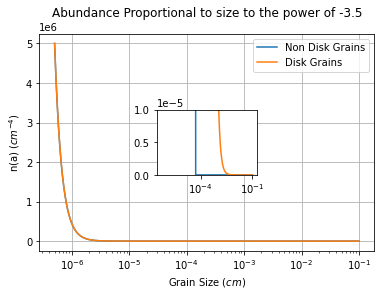

In [4]:
# 4 Nebula Content Parameters, Grain Parameters, and Plotting the Grain Size Distributions
pi = 3.1415926 # Pi
mdot_solar_masses = 8e-5 # solar masses, Guess mass loss rate of all molecules - Default : 8e-5
mdot = mdot_solar_masses * 2e33 / (365 * 24 * 60 * 60) # g / seconds, Mass loss rate of all molecules
mdot_lat_dependence = 1 # Latitude dependence factor of mass loss as described in paper - Default : 1.2
particle_radius_min = 5e-7 # cm, Minimum radius of the dust particles - Default : 5e-7
particle_radius_max = 5e-5 # cm, Maximum radius of the dust particles - Default : 5e-5
particle_radius_max_disk = 0.1 # cm, Maximum radius of the dust particles in the disk - Default : 0.1
size_distribution_exponent = -3.5 # Exponent factor of the dust grain number distribution to the grain size, as seen in Mathis (1977)
wavelength = 5.47e-5 # cm, Wavelength used by the observing telescope - Default : 5.47e-5
dust_to_gas = 1 / 200 # Guess dust to gas ratio - Default : 1 / 200
grain_density = 3 # grams / cm^3, Density of the individual grains - Default : 3
asymmetry_constant = 0.5 # The scattering asymmetry constant (overwritten in block # 20) - Default : 0.5

grain_sizes = np.logspace(np.log10(particle_radius_min), np.log10(particle_radius_max_disk), 10000) # Preparing to Plot the Grain Size Distributions

normalization_constant = (size_distribution_exponent + 1) / (particle_radius_max ** (size_distribution_exponent + 1) - particle_radius_min ** (size_distribution_exponent + 1))
normalization_constant_disk = (size_distribution_exponent + 1) / (particle_radius_max_disk ** (size_distribution_exponent + 1) - particle_radius_min ** (size_distribution_exponent + 1))

non_disk_grains = np.where((grain_sizes >= particle_radius_min) & (grain_sizes <= particle_radius_max), normalization_constant * grain_sizes ** size_distribution_exponent, 0)
disk_grains = np.where((grain_sizes >= particle_radius_min) & (grain_sizes <= particle_radius_max_disk), normalization_constant_disk * grain_sizes ** size_distribution_exponent, 0)

plt.plot(grain_sizes, non_disk_grains, label = 'Non Disk Grains')
plt.plot(grain_sizes, disk_grains, label = 'Disk Grains')

plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Grain Size ($cm$)')
plt.ylabel('n(a) ($cm^{-4}$)')
plt.title(f'Abundance Proportional to size to the power of {size_distribution_exponent}')
plt.legend()
plt.grid(True)

axins = inset_axes(plt.gca(), width = "30%", height = "30%", loc = 10)

axins.plot(grain_sizes, non_disk_grains, label = 'Non Disk Grains')
axins.plot(grain_sizes, disk_grains, label = 'Disk Grains')

axins.set_xscale('log')

axins.set_ylim(0, 1e-5)

plt.savefig('Figure 9.png', dpi = 100)
plt.show()

/tmp/ipykernel_2175041/3261113389.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  scattering_efficiency_integral = quad(lambda a: a ** (2 + size_distribution_exponent) * scattering_efficiency_function(2 * pi * a / wavelength), particle_radius_min, particle_radius_max)[0] # Values for the integral terms shown in paper
/tmp/ipykernel_2175041/3261113389.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scattering_efficiency_integral_disk = quad(lambda a: a *

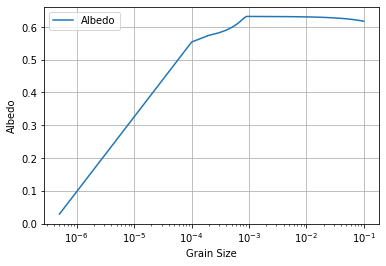

In [5]:
# 5 Pre-compute Dust Grain Properties, and Plotting Albedo vs. Grain Size 
cross_section_constant = 3 * (size_distribution_exponent + 4) / (4 * grain_density * (particle_radius_max ** (size_distribution_exponent + 4) - particle_radius_min ** (size_distribution_exponent + 4))) # Left constant expression shown in paper
cross_section_constant_disk = 3 * (size_distribution_exponent + 4) / (4 * grain_density * (particle_radius_max_disk ** (size_distribution_exponent + 4) - particle_radius_min ** (size_distribution_exponent + 4))) # Left constant expression shown in paper
scattering_efficiency_function_array = np.vstack((np.array([[0, 0]]), np.asarray(np.loadtxt('scattering_efficiency.csv', delimiter = ',')).astype('float32'), np.array([[99999, 1]]))) # Array form of scattering efficiency function
extinction_efficiency_function_array = np.vstack((np.array([[0, 0]]), np.asarray(np.loadtxt('extinction_efficiency.csv', delimiter = ',')).astype('float32'), np.array([[99999, 2]]))) # Array form of extinction efficiency function
scattering_efficiency_function = interp1d(scattering_efficiency_function_array[:, 0], scattering_efficiency_function_array[:, 1], kind = 'linear') # Function form of scattering efficiency function
extinction_efficiency_function = interp1d(extinction_efficiency_function_array[:, 0], extinction_efficiency_function_array[:, 1], kind = 'linear') # Function form of extinction efficiency function
scattering_efficiency_integral = quad(lambda a: a ** (2 + size_distribution_exponent) * scattering_efficiency_function(2 * pi * a / wavelength), particle_radius_min, particle_radius_max)[0] # Values for the integral terms shown in paper
scattering_efficiency_integral_disk = quad(lambda a: a ** (2 + size_distribution_exponent) * scattering_efficiency_function(2 * pi * a / wavelength), particle_radius_min, particle_radius_max_disk)[0]
extinction_efficiency_integral = quad(lambda a: a ** (2 + size_distribution_exponent) * extinction_efficiency_function(2 * pi * a / wavelength), particle_radius_min, particle_radius_max)[0]
extinction_efficiency_integral_disk = quad(lambda a: a ** (2 + size_distribution_exponent) * extinction_efficiency_function(2 * pi * a / wavelength), particle_radius_min, particle_radius_max_disk)[0]
scattering_cross_section = cross_section_constant * scattering_efficiency_integral # Pre-compute the values for the scattering/extinction cross section factors
scattering_cross_section_disk = cross_section_constant_disk * scattering_efficiency_integral_disk
extinction_cross_section = cross_section_constant * extinction_efficiency_integral
extinction_cross_section_disk = cross_section_constant_disk * extinction_efficiency_integral_disk

grain_sizes = np.linspace(particle_radius_min, particle_radius_max_disk, 1000)

scattering_efficiency = scattering_efficiency_function(2 * pi * grain_sizes / wavelength)
extinction_efficiency = extinction_efficiency_function(2 * pi * grain_sizes / wavelength)

plt.plot(grain_sizes, scattering_efficiency / extinction_efficiency, label = 'Albedo')

plt.xscale('log')

plt.xlabel('Grain Size')
plt.ylabel('Albedo')
plt.legend()
plt.grid(True)

plt.savefig('Figure 10.png', dpi = 100)
plt.show()

In [6]:
# 7 Logistic functions
def norm(x):
    return sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2])
  # norm(): returns the norm of a given vector x (the vector is in the form of np.array([x, y, z]))

def vector_angle(v1, v2):
    norm1 = norm(v1)
    norm2 = norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    else:
        factor = np.dot(v1, v2) / (norm1 * norm2)
        if factor > 1:
            return 0
        elif factor < -1:
            return pi
        else:
            return acos(factor)
    # vector_angle(): returns the angle between two cartesian vectors

def spherical_to_cartesian(r):
    sin_cur = sin(r[1])
    return np.array([r[0] * sin_cur * cos(r[2]), r[0] * sin_cur * sin(r[2]), r[0] * cos(r[1])])
  # spherical_to_cartesian(): returns the cartesian representation of the given spherical vector r
  # the cartesian vector x is defined in the refernce frame of nebula, not the observer

def cartesian_to_spherical(x):
    norm = sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2]) # pre compute the norm of the vector
    if norm == 0:
        return np.array([0, 0, 0])
    elif x[0] == 0:
        return np.array([norm, acos(x[2] / norm), pi / 2])
    else:
        return np.array([norm, acos(x[2] / norm), atan(x[1] / x[0])])
    # cartesian_to_spherical(): returns the spherical representation of the cartesian vector x
    # the cartesian vector x is defined in the reference frame of nebula, not the observer

In [7]:
# 8 Scattering Phase Function
def phase_function(angle): # Henyey-Greenstein
    return 1 / (4 * pi) * (1 - asymmetry_constant * asymmetry_constant) / ((1 + asymmetry_constant * asymmetry_constant - 2 * asymmetry_constant * cos(angle)) ** (3 / 2))

In [8]:
# 9 Array Coordinate - Skyplane Coordinate Translations
def coord_to_index(x, y): 
    # coord_to_index(): Returns the array index i given the skyplane coordinates x, y in cm 
    return int(int(((x / view_size) + 1) * (resolution / 2)) + int((y / view_size) * (resolution / 2)) * (resolution + 1))
def index_to_x(i):
    # index_to_x(): Returns the skyplane coordinate x given the array index i
    return (int(i % (resolution + 1)) / (resolution / 2) - 1) * view_size
def index_to_y(i):
    # index_to_y(): Returns the skyplane coordinate y given the array index i
    return (int(i / (resolution + 1)) / (resolution / 2)) * view_size

In [9]:
# 10 Define Spherical and Cubical Optical Depth Integration Function
def optical_depth_center_progression(latitude, distance):
    # optical_depth_center_progression(): Optical depth between two close points
    total = 0 # total
    i = 0 # iterator
    while i < 1:
        extinction_cross_section = density(latitude, distance + i * (view_size / (distance_steps * absorption_steps_center)))[1]
        total += extinction_cross_section # add the non constant density
        i += 1 / absorption_steps_center
    total = total * (2 * view_size / (distance_steps * absorption_steps_center))
    # now multiply the constants of the integrand
    return total

view_size = view_length / 2 # cm, Half the size of the picture
angular_size = view_size / (distance_ly / 2.18e-13) # arcseconds, Size of the nebula in angular units
real_half_resolution = int(angular_size / pixel_size) - 1 # Number of HST sized pixels half our image length correspond to
simulated_pixel_size = 2 * angular_size / (resolution + 1) # Size of the ximulated pixels

n = 2 * view_size / (resolution + 1)
def optical_depth_progression(x1, x2):
    # optical_depth_progression(): Optical depth between two close points
    total = 0 # total
    i = 0 # iterator
    while i < 1:
        extinction_cross_section = density_cartesian(x1 + i * (x2 - x1))[1]
        total += extinction_cross_section # add the non constant density
        i += 1 / absorption_steps
    total = total * n / absorption_steps # now multiply the constants of the integrand
    return total # return the result

In [10]:
# 11 Defining the Optical Intensity Function
@np.vectorize
def intensity(x, y):
    total = 0.0
    # total number of unit photons reaching the specified pixel
    i = coord_to_index(x, y)
    for j in range(0, resolution + 1):
        
        depth = view_size - (1 + 2 * j) * view_size / (resolution + 1)
        
        cur = np.array([float(x * sin_obs_lat + depth * cos_obs_lat), float(y), float(-x * cos_obs_lat + depth * sin_obs_lat)])
        # current point (precise value stored in array)
        spherical = cartesian_to_spherical(cur) 
        # spherical of current point, to find the optical depth center
        o_d_center = scale_factor * optical_depth_center_array[abs(int((angle_steps / 90) * (90 - (180 * spherical[1] / pi))))][int(spherical[0] / (2 * view_size) * distance_steps)]
        # optical depth from center
        o_d = scale_factor * optical_depth_array[i][j]
        # optical depth from point of interest to earth
        # the amount of photons from that point
        if x == 0 and y == 0 and j == resolution / 2: # point of interest is central star
            add = mpmath.exp(-scale_factor * optical_depth_array[coord_to_index(0, 0)][int(j)]) / ((view_length / (resolution + 1)) * (view_length / (resolution + 1)))
        else:
            scattering_cross_section = density(pi / 2 - spherical[1], spherical[0])[0]
            add = (1 / (4 * pi * ((spherical[0]) * (spherical[0])))) * mpmath.exp(-o_d) * mpmath.exp(-o_d_center) * scale_factor * scattering_cross_section * (view_length / (resolution + 1)) * phase_function(vector_angle(np.array([cos_obs_lat, 0, sin_obs_lat]), cur))
        total += add
    return total

In [11]:
# 12 Computing the Point Spread Function (PSF)
data = fits.open("f547m_80s_raw_1.fits")[0].data[0]
            
n = 9

psf_x = 406
psf_y = 478
    
psf_profile = data[psf_x - n + 1 : psf_x + n, psf_y - n + 1 : psf_y + n] / data[psf_x - n + 1 : psf_x + n, psf_y - n + 1 : psf_y + n].ravel().sum()

n = 9

psf_x = 508
psf_y = 190
    
psf_profile = psf_profile / 2 + data[psf_x - n + 1 : psf_x + n, psf_y - n + 1 : psf_y + n] / 2 / data[psf_x - n + 1 : psf_x + n, psf_y - n + 1 : psf_y + n].ravel().sum()

0.20182686731948032
0.19634516350863673


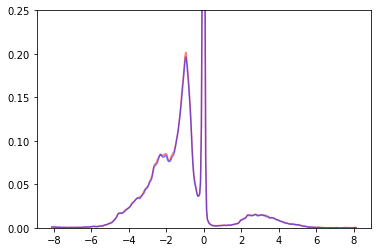

In [12]:
# 13 Computing the Star to Lobe Ratio

hst_image = fits.open("80_raw_1.fits")[0].data[0]

x_array = np.linspace(-real_half_resolution * pixel_size, real_half_resolution * pixel_size, real_half_resolution * 2 + 1)

center_x = 412
center_y = 407

angle_degrees = 105

start_x = 150 + np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_x = 150 - np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
start_y = 150 + np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_y = 150 - np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size

y_hst = skimage.measure.profile_line(hst_image[center_x - 150 : center_x + 150, center_y - 150 : center_y + 150], [start_x, start_y], [end_x, end_y], linewidth = 3)
x_hst = np.linspace(-(len(y_hst) - 1) / 2 *  pixel_size, (len(y_hst) - 1) / 2 *  pixel_size, len(y_hst))
y_hst = np.delete(y_hst, int(len(y_hst) / 2))
y_hst = np.insert(y_hst, int(len(y_hst) / 2), hst_image[center_x, center_y])
x_hst = np.delete(x_hst, int(len(y_hst) / 2))
x_hst = np.insert(x_hst, int(len(y_hst) / 2), 0)

y_hst_scaled = np.interp(x_array, x_hst, y_hst)

normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, normalizedYHST, color = 'red', alpha = 0.5, label = 'HST')

plt.ylim(0, 0.2)

true_star_value = float(np.max(normalizedYHST))
true_lobe_value = float(np.max(normalizedYHST[0 : int(len(normalizedYHST) / 2 - 3)]))
# print(star_value)
print(true_lobe_value)
# print(star_value / lobe_value)

hst_image = fits.open("80_raw_2.fits")[0].data[0]

x_array = np.linspace(-real_half_resolution * pixel_size, real_half_resolution * pixel_size, real_half_resolution * 2 + 1)

center_x = 412
center_y = 407

angle_degrees = 105

start_x = 150 + np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_x = 150 - np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
start_y = 150 + np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_y = 150 - np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size

y_hst = skimage.measure.profile_line(hst_image[center_x - 150 : center_x + 150, center_y - 150 : center_y + 150], [start_x, start_y], [end_x, end_y], linewidth = 3)
x_hst = np.linspace(-(len(y_hst) - 1) / 2 *  pixel_size, (len(y_hst) - 1) / 2 *  pixel_size, len(y_hst))
y_hst = np.delete(y_hst, int(len(y_hst) / 2))
y_hst = np.insert(y_hst, int(len(y_hst) / 2), hst_image[center_x, center_y])
x_hst = np.delete(x_hst, int(len(y_hst) / 2))
x_hst = np.insert(x_hst, int(len(y_hst) / 2), 0)

y_hst_scaled = np.interp(x_array, x_hst, y_hst)

normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, normalizedYHST, color = 'blue', alpha = 0.5, label = 'HST')

plt.ylim(0, 0.25)

true_star_value = float(np.max(normalizedYHST))
true_lobe_value = float(np.max(normalizedYHST[0 : int(len(normalizedYHST) / 2 - 3)]))
# print(star_value)
print(true_lobe_value)
plt.show()

12405.343351403973
67.97397317860035
4
9018.47264464078
67.97397317860035
6
7964.407973485144
67.97397317860035
7.0
7530.030423376869
67.97397317860035
7.5
7331.330479315629
67.97397317860035
7.75
7236.145028389795
67.97397317860035
7.875
7189.54215691412
67.97397317860035
7.9375
7166.482177347972
67.97397317860035
7.96875
7155.011826751928
67.97397317860035
7.984375
7149.290600195755
67.97397317860035
7.9921875


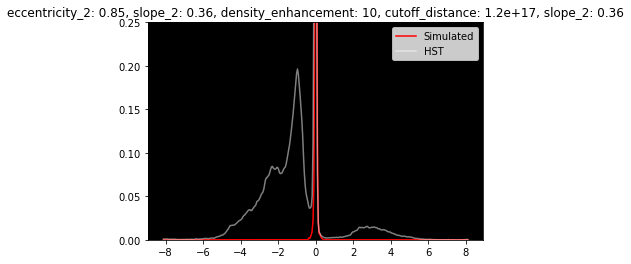

12405.343351403973
67.97397317860035
4
9018.47264464078
67.97397317860035
6
7964.407973485144
67.97397317860035
7.0
7530.030423376869
67.97397317860035
7.5
7331.330479315629
67.97397317860035
7.75
7236.145028389795
67.97397317860035
7.875
7189.54215691412
67.97397317860035
7.9375
7166.482177347972
67.97397317860035
7.96875
7155.011826751928
67.97397317860035
7.984375


KeyboardInterrupt: 

In [13]:
plot_number = 1
for eccentricity_2 in eccentricity_2_values:
    for slope_2 in slope_2_values:
        for density_enhancement in density_enhancement_values:
            for focus_2 in focus_2_values:
                for cutoff_distance_2 in cutoff_distance_2_values:

                    observing_latitude = pi * (observing_latitude_degrees / 180) # radians, Observing latitude 
                    sin_obs_lat = sin(observing_latitude) # precompute the trigs of the observer
                    cos_obs_lat = cos(observing_latitude)                    
                    directrix = -(focus + focus_shift) / eccentricity - focus_shift # cm, Location of the directrix of the conic shaped lobe - Default : -view_length / 10.9ansa_eccentricity = 0.55 # Eccentricity of the ansa - Default : 0.85
                    directrix_2 = -(focus_2 + focus_shift_2) / eccentricity_2 - focus_shift_2

                    x, y = sp.symbols('x y')
                    eq1 = sp.Eq((eccentricity * (x - directrix)) * (eccentricity * (x - directrix)) - x * x - focus * focus + 2 * x * focus - y ** 2, 0) # Outer conic section formula
                    eq2 = sp.Eq((x + focus_shift) ** 2 + y ** 2 - cutoff_distance ** 2, 0) # The point distance to the center has to be equal to cutoff_distance
                    sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
                    x_cut = abs(sol[3][0]) # x coordinate of the point
                    y_cut = abs(sol[3][1]) # y coordinate of the point

                    x, y = sp.symbols('x y')
                    eq1 = sp.Eq((eccentricity_2 * (x - directrix_2)) * (eccentricity_2 * (x - directrix_2)) - x * x - focus_2 * focus_2 + 2 * x * focus_2 - y ** 2, 0) # Inner conic section formula
                    eq2 = sp.Eq((x + focus_shift_2) ** 2 + y ** 2 - cutoff_distance_2 ** 2, 0) # The point distance to the center has to be equal to cutoff_distance_2
                    sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
                    x_cut_2 = abs(sol[3][0]) # x coordinate of the point
                    y_cut_2 = abs(sol[3][1]) # y coordinate of the point

                    y_intercept = y_cut + slope * x_cut # Calculates the y-intercept of the outer linear boundary
                    y_intercept_2 = y_cut_2 + slope_2 * x_cut_2 # y_cut_2 + slope * x_cut_2 # Calculates the y-intercept of the inner linear boundary

                    def lobe(x):
                        x = abs(x)
                        y_2_squared = (eccentricity_2 * (x - directrix_2)) * (eccentricity_2 * (x - directrix_2)) - x * x - focus_2 * focus_2 + 2 * x * focus_2
                        y_2 = sqrt(y_2_squared * (y_2_squared >= 0))
                        y_squared = (eccentricity * (x - directrix)) * (eccentricity * (x - directrix)) - x * x - focus * focus + 2 * x * focus
                        y = sqrt(y_squared * (y_squared >= 0))
                        y_2_alt = y_intercept_2 - x * slope_2
                        y_alt = y_intercept - x * slope
                        if x > x_cut_2:
                            return (y_2_alt, y_alt) if x > x_cut else (y_2_alt, y)
                        return (y_2, y_alt) if x > x_cut else (y_2, y)

                    def ansa(x):

                        x = abs(x)
                        y_squared = (ansa_eccentricity * (x - ansa_directrix)) * (ansa_eccentricity * (x - ansa_directrix)) - x * x - ansa_focus * ansa_focus + 2 * x * ansa_focus

                        return sqrt(y_squared * (y_squared >= 0))

                    def find_density(x, y, latitude, distance):

                        if abs(latitude) >= 85 / 180 * pi and distance > 3e17:

                            velocity = 7.5e7 # cm/s - Default : 2e7

                            mass_density = (dust_to_gas * mdot) / (4 * pi * (distance * distance) * velocity)

                            return scattering_cross_section * mass_density, extinction_cross_section * mass_density, mass_density

                        elif distance >= 2.5e17:

                            return 0, 0, 0

                        sin_lat = abs(x / distance)
                        sin_lat_squared = sin_lat * sin_lat
                        cos_lat_squared = 1 - sin_lat_squared

                        a = mdot_lat_dependence
                        b = 1 / (a * a)

                        mdot_factor = sqrt(((a ** 4 * cos_lat_squared) + (b ** 4 * sin_lat_squared)) / (a * a * cos_lat_squared + b * b * sin_lat_squared))

                        if y < ansa(x):

                            velocity = 5e5 # cm/s - Default : 5e5

                            mass_density = mdot_factor * dust_to_gas * mdot / (16 * pi * 1e34 * velocity)

                            return scattering_cross_section * mass_density, extinction_cross_section * mass_density, mass_density

                        y_low, y_high = lobe(x)

                        if distance < rin * 2: 

                            cutoff_inner = 0.5 * (1 - tanh((rin - distance) / (rin / 10)))

                        else: 

                            cutoff_inner = 1

                        if y <= y_high: 

                            cutoff_outer = 0.5 * (1 - tanh((distance - 1.9e17) / 1e16))

                            if y <= y_low: 

                                velocity = 5e7 # cm/s - Default : 7.5e7

                                area = pi * y_low * y_low

                                mass_density = cutoff_outer * cutoff_inner * mdot_factor * dust_to_gas * mdot / (16 * area * velocity)

                                return scattering_cross_section * mass_density, extinction_cross_section * mass_density, mass_density

                            # velocity = 2e7 / density_enhancement / (distance * distance * distance / 1e51)  # cm/s - Default : 2e7

                            velocity = 2e7 / density_enhancement / (distance * distance / 1e34)

                            # cutoff_mid_low = 1 + 2.5 * (1 - tanh((distance - 9e16) / 1e16))

                            # cutoff_mid_high = 3 - 1 * (1 - tanh((distance - 1.5e17) / 1e16))

                            # if distance >= 1.5e17: 
                                # velocity = velocity / (distance / 1.5e17)

                            # if abs(x) >= 0 and abs(x) <= 9e16:
                                # velocity = velocity / 6

                            # if abs(x) >= 1.5e17 and abs(x) <= 3e17:
                                # velocity = velocity / 2 # previous change from 2 to 4

                            mass_density = cutoff_outer * mdot_factor * dust_to_gas * mdot / (4 * pi * (distance * distance) * velocity)

                            return scattering_cross_section * mass_density, extinction_cross_section * mass_density, mass_density

                        else: 

                            R_cur_low = 8e16 # cm, cutoff radius - Default : 1.1e17
                            R_cur_high = 1.5e17
                            R_cur = 0 # R_cur_high * R_cur_low / sqrt(R_cur_low ** 2 * sin_lat_squared + R_cur_high ** 2 * (1 - sin_lat_squared))

                            R_cur = max([R_cur, 1e17])

                            dr_cur = 2e15 * (1 + 10 * cos_lat_squared) # cm, sharpness of cutoff - Default : 1.2e16

                            if False: # distance >= R_cur_high + 5 * dr_cur:

                                return 0, 0, 0

                            else: 
                                velocity = 5e5 # cm/s

                        cutoff_outer = 0.5 * (1 - tanh((distance - R_cur) / dr_cur))

                        mass_density = mdot_factor * (dust_to_gas * mdot) * (cutoff_outer * cutoff_inner) / (4 * pi * (distance * distance) * velocity)

                        return scattering_cross_section * mass_density, extinction_cross_section * mass_density, mass_density

                    def density_cartesian(r):

                        spherical = cartesian_to_spherical(r)
                        latitude, distance = pi / 2 - spherical[1], spherical[0]

                        if distance < rin / 2:

                            return 0, 0, 0

                        y = sqrt(r[0] * r[0] + r[1] * r[1])
                        x = r[2] # Along the sky plane the symmetric axis is the horizontal x-axis, but in the 3D distribution it's the z-axis

                        return find_density(x, y, latitude, distance)

                    def density(latitude, distance):

                        if distance < rin / 2:

                            return 0, 0, 0

                        x = distance * sin(latitude)
                        y = sqrt(distance * distance - x * x)

                        return find_density(x, y, latitude, distance)

                    i, j = distance_steps + 1, angle_steps + 1
                    optical_depth_center_array = [[0 for x in range(i)] for y in range(j)]

                    for i in range(0, angle_steps):
                        for j in range(0, distance_steps):

                            # For each angle, accumulatively compute the optical depth
                            add = optical_depth_center_progression(i * pi / (2 * angle_steps), j * (2 * view_size / distance_steps))
                            optical_depth_center_array[i][j] = optical_depth_center_array[i][j - 1] + add
                    # print(optical_depth_center_array[angle_steps - 1][distance_steps - 1])
                    i, j = resolution + 1, (resolution + 1) * (int(resolution / 2) + 1)
                    optical_depth_array = [[0 for x in range(i)] for y in range(j)]

                    r = (resolution + 1) * (int(resolution / 2) + 1) - 1
                    required = np.asarray(np.loadtxt('required_coordinates.csv', delimiter = ' ')).astype('int')
                    # print("here 1")
                    for i in required:
                        for j in range(0, resolution + 1):

                            # stdout.write("\rProgress: " + str(np.int(i / r + j / r / (resolution - 1))) + "%")
                            # stdout.flush()

                            if j == 0: 
                                optical_depth_array[i][j] = 0
                                continue # jump out the current j loop

                            # For each coordinate, accumulate the optical depth along the line of sight
                            x = index_to_x(i)
                            y = index_to_y(i)

                            depth = view_size - (1 + 2 * j) * view_size / (resolution + 1)
                            depth_prev = view_size - (1 + 2 * (j - 1)) * view_size / (resolution + 1)

                            add = optical_depth_progression(np.array([x * sin_obs_lat + depth * cos_obs_lat, y, -x * cos_obs_lat + depth * sin_obs_lat]), np.array([x * sin_obs_lat + depth_prev * cos_obs_lat, y, -x * cos_obs_lat + depth_prev * sin_obs_lat]))

                            optical_depth_array[i][j] = optical_depth_array[i][j - 1] + add
                    
                    @np.vectorize
                    def intensity(x, y):
                        total = 0.0
                        # total number of unit photons reaching the specified pixel
                        i = coord_to_index(x, y)
                        for j in range(0, resolution + 1):

                            depth = view_size - (1 + 2 * j) * view_size / (resolution + 1)

                            cur = np.array([float(x * sin_obs_lat + depth * cos_obs_lat), float(y), float(-x * cos_obs_lat + depth * sin_obs_lat)])
                            # current point (precise value stored in array)
                            spherical = cartesian_to_spherical(cur) 
                            # spherical of current point, to find the optical depth center
                            o_d_center = scale_factor * optical_depth_center_array[abs(int((angle_steps / 90) * (90 - (180 * spherical[1] / pi))))][int(spherical[0] / (2 * view_size) * distance_steps)]
                            # optical depth from center
                            o_d = scale_factor * optical_depth_array[i][j]
                            # optical depth from point of interest to earth
                            # the amount of photons from that point
                            if x == 0 and y == 0 and j == resolution / 2: # point of interest is central star
                                add = mpmath.exp(-scale_factor * optical_depth_array[coord_to_index(0, 0)][int(j)]) / ((view_length / (resolution + 1)) * (view_length / (resolution + 1)))
                            else:
                                scattering_cross_section = density(pi / 2 - spherical[1], spherical[0])[0]
                                add = (1 / (4 * pi * ((spherical[0]) * (spherical[0])))) * mpmath.exp(-o_d) * mpmath.exp(-o_d_center) * scale_factor * scattering_cross_section * (view_length / (resolution + 1)) * phase_function(vector_angle(np.array([cos_obs_lat, 0, sin_obs_lat]), cur))
                            total += add
                        return total
                    
                    asymmetry_constant = 0.6
                    scale_factor = 4
                    scale_factor_increment = 2
                    found = False

                    kernel_center = np.max(psf_profile)

                    true_lobe_value = true_lobe_value
                    # print("here 2")
                    while_count = 0
                    while(found == False):
                        
                        while_count = while_count + 1
                        side = np.linspace(-view_size, 0, int(resolution / 2) + 1)
                        sideY = np.linspace(0, 0, 1)
                        x, y = np.meshgrid(side, sideY)
                        np.seterr(divide = 'ignore')
                        Value = np.asarray(intensity(x, y)).astype('float32')[0]

                        star_value = float(np.max(Value))
                        lobe_value = float(np.partition(Value, -2)[-2])
                        
                        ratio = star_value / lobe_value
                        
                        print(ratio)
                        print(1 / kernel_center / true_lobe_value * (pixel_size ** 2 / simulated_pixel_size ** 2))
                        print(scale_factor)
                        
                        if np.abs(ratio - 1 / kernel_center / true_lobe_value * (pixel_size ** 2 / simulated_pixel_size ** 2)) <= 0.1: 
                            print("here 4")
                            found = True
                            break
                        
                        elif while_count >= 10:
                            break
                        
                        if ratio >= 1 / kernel_center / true_lobe_value * (pixel_size ** 2 / simulated_pixel_size ** 2):
                            scale_factor = scale_factor + scale_factor_increment
                            scale_factor_increment = scale_factor_increment / 2
                        else:
                            scale_factor = scale_factor - scale_factor_increment
                            scale_factor_increment = scale_factor_increment / 2

                    # print("here")
                    plt.figure(plot_number)
                    plt.title(f'eccentricity_2: {eccentricity_2}, slope_2: {slope_2}, density_enhancement: {density_enhancement}, cutoff_distance: {cutoff_distance}, slope_2: {slope_2}')
                    # print("here")
                    side = np.linspace(-view_size, view_size, resolution + 1)
                    sideY = np.linspace(0, 0, 1)
                    x, y = np.meshgrid(side, sideY)
                    np.seterr(divide = 'ignore')
                    Value = np.asarray(intensity(x, y)).astype('float32')[0]

                    calculated_star_value = Value[int(resolution / 2)]

                    x_array = np.linspace(-angular_size, angular_size, resolution + 1)

                    x_array_real = np.linspace(-real_half_resolution * pixel_size, real_half_resolution * pixel_size, real_half_resolution * 2 + 1)

                    transformed_value = np.interp(x_array_real, x_array, Value)

                    transformed_value[real_half_resolution] = calculated_star_value * (simulated_pixel_size ** 2) / (pixel_size ** 2) * np.sum(psf_profile[8])

                    kernel = psf_profile[8] / np.sum(psf_profile[8])
                    psf_conv_profile = convolve(transformed_value, kernel, mode = 'same')

                    convolved_star_value = np.max(np.nan_to_num(np.array(psf_conv_profile, dtype = float)))

                    normalizedYArray = psf_conv_profile / np.max(np.nan_to_num(np.array(psf_conv_profile, dtype = float)))

                    plt.plot(x_array_real, normalizedYArray, color = 'red', label = 'Simulated')

                    # plt.title("Estimated Brightness Along Symmetric Axis")

                    hst_image = fits.open("80_raw_2.fits")[0].data[0]

                    center_x = 412
                    center_y = 407

                    angle_degrees = 105

                    start_x = 150 + np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
                    end_x = 150 - np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
                    start_y = 150 + np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size
                    end_y = 150 - np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size

                    y_hst = skimage.measure.profile_line(hst_image[center_x - 150 : center_x + 150, center_y - 150 : center_y + 150], [start_x, start_y], [end_x, end_y], linewidth = 3)
                    x_hst = np.linspace(-(len(y_hst) - 1) / 2 *  pixel_size, (len(y_hst) - 1) / 2 *  pixel_size, len(y_hst))
                    y_hst = np.delete(y_hst, int(len(y_hst) / 2))
                    y_hst = np.insert(y_hst, int(len(y_hst) / 2), hst_image[center_x, center_y])
                    x_hst = np.delete(x_hst, int(len(y_hst) / 2))
                    x_hst = np.insert(x_hst, int(len(y_hst) / 2), 0)

                    y_hst_scaled = np.interp(x_array_real, x_hst, y_hst)

                    normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
                    plt.plot(x_array_real, normalizedYHST, color = 'white', alpha = 0.5, label = 'HST')

                    plt.ylim(0, 0.25)

                    plt.gca().set_facecolor('black')
                    plt.legend()

                    plt.show()

                    plot_number += 1
                    # print("here")